In [57]:
import polars as pl
_ = pl.Config(tbl_formatting="ASCII_MARKDOWN", tbl_hide_column_data_types=True, tbl_hide_dataframe_shape=True, set_tbl_rows=16)

In [58]:
import os
from os.path import join, dirname, abspath
from dotenv import find_dotenv, load_dotenv

_ = load_dotenv(find_dotenv())

In [59]:
from IPython.display import Image, Markdown

In [60]:
import seaborn as sns
sns.set(rc={'figure.figsize':(12, 6)})
import matplotlib.pyplot as plt

from typing import Sequence
from itertools import product
from src.addons.metrics import mean_reciprocal_rank, mean_average_precision, first_rank_accuracy

# Objectif

La [recherche d’images basée sur le contenu](https://fr.wikipedia.org/wiki/Recherche_d%27image_par_le_contenu) (CBIR) est une méthode permettant de rechercher des images à partir des caractéristiques visuelles, c’est-à-dire induites par les pixels. L'utilisation la plus connue de cette méthode est la fonction de recherche d'images du moteur de recherche Google. Elle s'effectue en quatre étapes :

1. Extraction des caractéristiques d'une base de données d'images pour former une base de données des caractéristiques,
2. Extraction des caractéristiques de l'image fournie en entrée,
3. Recherche des caractéristiques les plus similaires dans la base de données,
4. Retour de l'image associée aux caractéristiques trouvées.

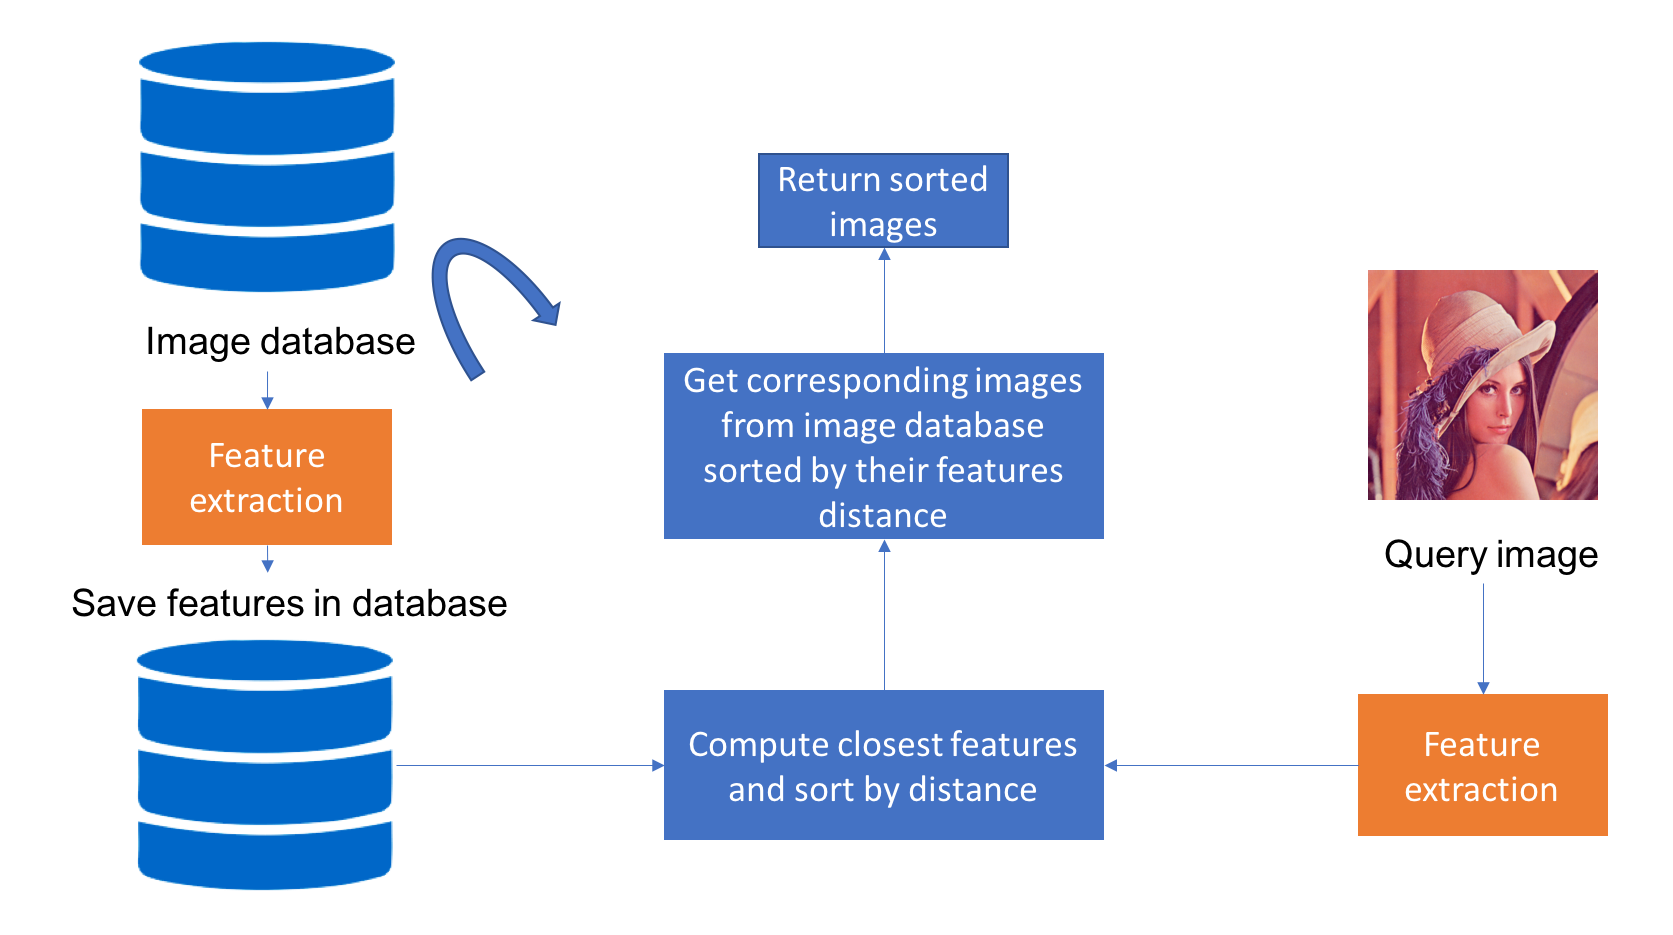

In [61]:
Image(join(dirname(abspath(".")), "reports", "images", "cbir.png"))

Cette méthode répose sur l'algorithme d'extraction et la comparaison des caractéristiques.

## Mesure de similarité
* [Similarité cosinus](https://fr.wikipedia.org/wiki/Similarit%C3%A9_cosinus)
* [Distance de manhattan](https://fr.wikipedia.org/wiki/Distance_de_Manhattan)
* [Distance euclidienne](https://fr.wikipedia.org/wiki/Espace_euclidien)

## Algorithme d'extraction
* [AKAZE](https://docs.opencv.org/3.4/db/d70/tutorial_akaze_matching.html)
* [ORB](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_orb/py_orb.html)
* [VGG16](https://neurohive.io/en/popular-networks/vgg16/)
* [NasNet](https://paperswithcode.com/model/nasnet?variant=nasnetalarge)
* [EfficientNet](https://paperswithcode.com/method/efficientnet)

**L'objectif de trouver la bonne combinaisons (algorithme d'extraction & mesure de similarité) qui permet d'avoir des réponses pertinentes.**

# Jeux de données
Nous avons utilisé le jeu de donnée [Apparel](https://www.kaggle.com/trolukovich/apparel-images-dataset) pour notre évaluation.

In [62]:
input_path = os.environ.get("INPUT_PATH")
train_size = pl.read_parquet(join(input_path, "train.parquet")).shape[0]
test_size = pl.read_parquet(join(input_path, "test.parquet")).shape[0]

In [63]:
print(f"Elle contient 11385 images réparties en 37 catégories, divisé en deux jeux :"
 f"- jeu d'entraînement: {train_size} images"
 f"- jeu de test: {test_size}")

Elle contient 11385 images réparties en 37 catégories, divisé en deux jeux :- jeu d'entraînement: 10833 images- jeu de test: 5337



# Evaluation

## Diversité de des données

L'ensemble des algorithmes d'extraction a reçu le même nombre d'images pour constituer les bases de données. Néanmoins, certains n'ont pas pu extraire les données de toutes les images.

In [64]:
feature_path = os.environ.get("FEATURE_PATH")
akaze_size = pl.read_parquet(join(feature_path, "AKAZE_db.parquet")).shape[0]
orb_size = pl.read_parquet(join(feature_path, "ORB_db.parquet")).shape[0]
vgg_size = pl.read_parquet(join(feature_path, "VGG_db.parquet")).shape[0]
nasnet_size = pl.read_parquet(join(feature_path, "NasNet_db.parquet")).shape[0]
efficient_size = pl.read_parquet(join(feature_path, "EfficientNet_db.parquet")).shape[0]

In [65]:
data_size = pl.DataFrame({
  "AKAZE": [akaze_size],
  "ORB": [orb_size],
  "VGG": [vgg_size],
  "NasNet": [nasnet_size],
  "EfficientNet": [efficient_size]
})
Markdown(str(data_size))

| AKAZE | ORB   | VGG   | NasNet | EfficientNet |
|-------|-------|-------|--------|--------------|
| 10809 | 10832 | 10833 | 10833  | 10833        |

Les algorithmes basés sur des réseaux neuronaux n'ont pas eu de mal à extraire toutes les données, contrairement aux algorithmes basés sur les descripteurs, particulièrement AKAZE.

## Métriques d'évaluation
* Mean Average Precision (MAP) pour mesurer la robustesse du système
* Mean Reciprocal Rank (MRR) pour mesurer la pertinence du premier élément
* Temps de traitement d'une requête

Pour plus de détail [voir](https://web.stanford.edu/class/cs276/handouts/EvaluationNew-handout-1-per.pdf)

In [66]:
evaluation_path = os.environ.get("EVALUATION_PATH")

In [67]:
extractors = ("AKAZE", "ORB", "VGG", "NasNet", "EfficientNet")
distances = ("cosinus", "euclidean", "manhattan")
combination = list(product(extractors, distances))

In [68]:
def median_duration(data: pl.DataFrame) -> float:
    return data.select("duration").to_series().median()

def compute_mrr(data: pl.DataFrame, columns: Sequence[str]) -> float:
    retrievals = data.select(columns[0]).to_series().to_list()
    labels = data.select(columns[1]).to_series().to_list()
    return mean_reciprocal_rank(retrievals, labels)

def compute_map(data: pl.DataFrame, columns: Sequence[str]) -> float:
    retrievals = data.select(pl.col(columns[0])).to_series().to_list()
    labels = data.select(pl.col(columns[1])).to_series().to_list()
    return mean_average_precision(retrievals, labels)

def compute_first_rank(data: pl.DataFrame, columns: Sequence[str]) -> float:
    retrievals = data.select(columns[0]).to_series().to_list()
    labels = data.select(columns[1]).to_series().to_list()
    return first_rank_accuracy(retrievals, labels)

def compute_metrics(data: pl.DataFrame, columns: Sequence[str]) -> dict:
    return {
        "map": compute_map(data, columns),
        "mrr": compute_mrr(data, columns),
        "first_rank": compute_first_rank(data, columns),
        "median_duration": median_duration(data)
    }

In [69]:
def evaluation(gt_column: str, pred_column: str) -> pl.DataFrame:
    metrics = []
    for extractor, distance in combination:
        data = pl.read_parquet(join(evaluation_path, f"{extractor}_{distance}_evaluation.parquet"))
        res = {"method": f"{extractor}_{distance}"}
        res.update(compute_metrics(data=data, columns=[pred_column, gt_column]))
        metrics.append(res)
    return pl.DataFrame(metrics)

### Colors

In [70]:
evaluation_color = evaluation(gt_column="gt_color", pred_column="colors")
Markdown(str(evaluation_color))

| method                 | map      | mrr      | first_rank | median_duration |
|------------------------|----------|----------|------------|-----------------|
| AKAZE_cosinus          | 0.173069 | 0.175045 | 0.097433   | 0.04769         |
| AKAZE_euclidean        | 0.369149 | 0.385647 | 0.256511   | 0.027107        |
| AKAZE_manhattan        | 0.367451 | 0.384183 | 0.259134   | 0.034335        |
| ORB_cosinus            | 0.185993 | 0.189991 | 0.107176   | 0.040173        |
| ORB_euclidean          | 0.370821 | 0.389923 | 0.26157    | 0.020106        |
| ORB_manhattan          | 0.379763 | 0.397936 | 0.268128   | 0.028702        |
| VGG_cosinus            | 0.1065   | 0.107851 | 0.047405   | 0.141562        |
| VGG_euclidean          | 0.754663 | 0.788998 | 0.695522   | 0.103439        |
| VGG_manhattan          | 0.75357  | 0.786984 | 0.692524   | 0.114153        |
| NasNet_cosinus         | 0.118824 | 0.122606 | 0.079258   | 0.334193        |
| NasNet_euclidean       | 0.70725  | 0.738717 | 0.638936   | 0.297163        |
| NasNet_manhattan       | 0.700086 | 0.731934 | 0.634439   | 0.362533        |
| EfficientNet_cosinus   | 0.179325 | 0.183471 | 0.083005   | 0.254814        |
| EfficientNet_euclidean | 0.743807 | 0.777928 | 0.68428    | 0.231353        |
| EfficientNet_manhattan | 0.739458 | 0.771273 | 0.673787   | 0.237542        |

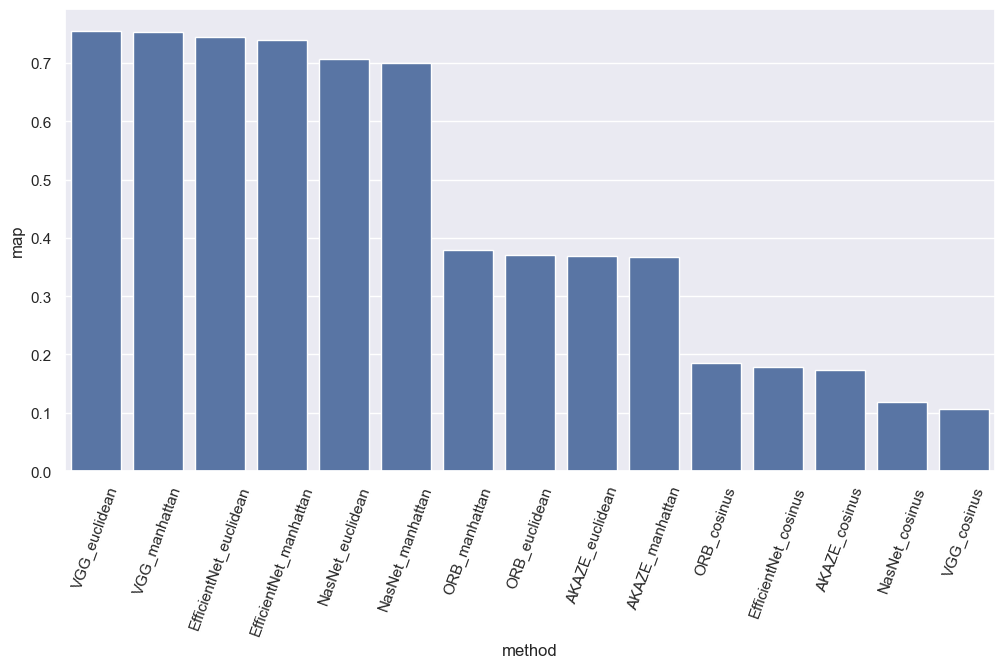

In [71]:
sns.barplot(data=evaluation_color.sort("map", descending=True), x="method", y="map")
plt.xticks(rotation=70)
plt.show()

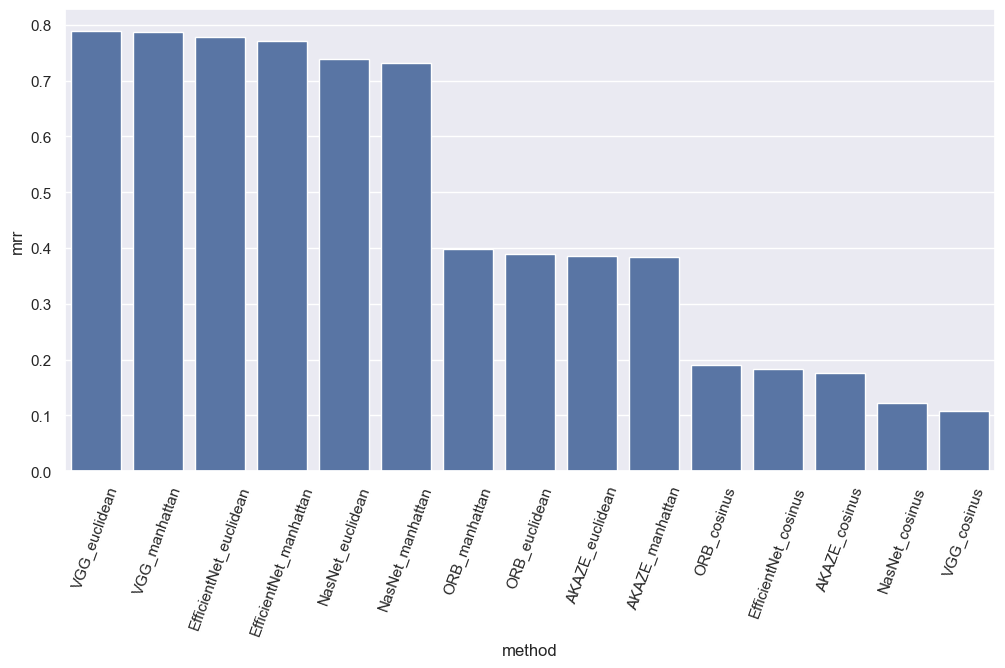

In [72]:
sns.barplot(data=evaluation_color.sort("mrr", descending=True), x="method", y="mrr")
plt.xticks(rotation=70)
plt.show()

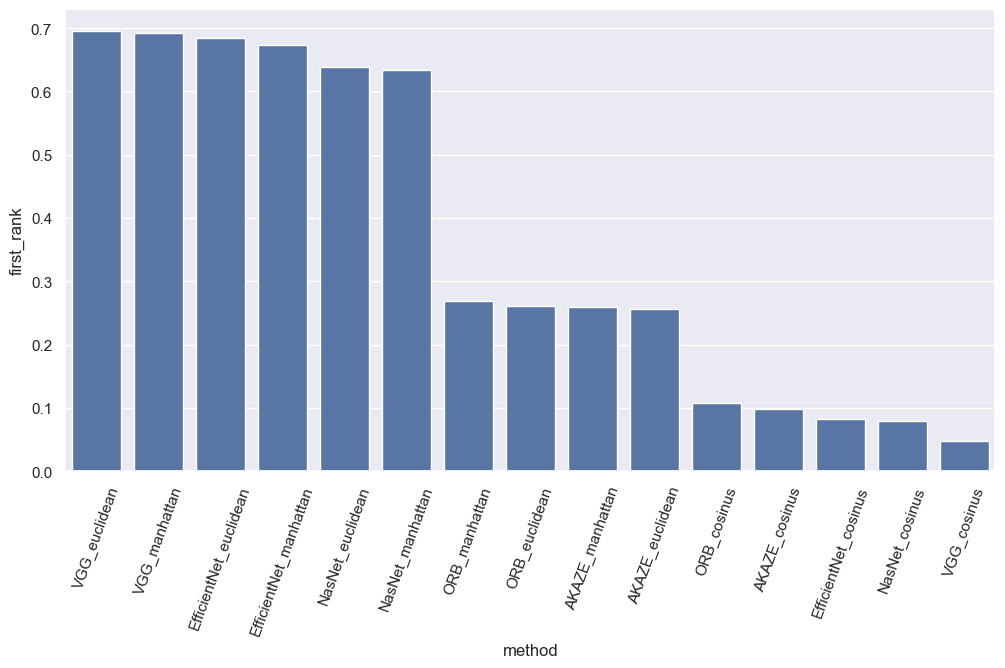

In [73]:
sns.barplot(data=evaluation_color.sort("first_rank", descending=True), x="method", y="first_rank")
plt.xticks(rotation=70)
plt.show()

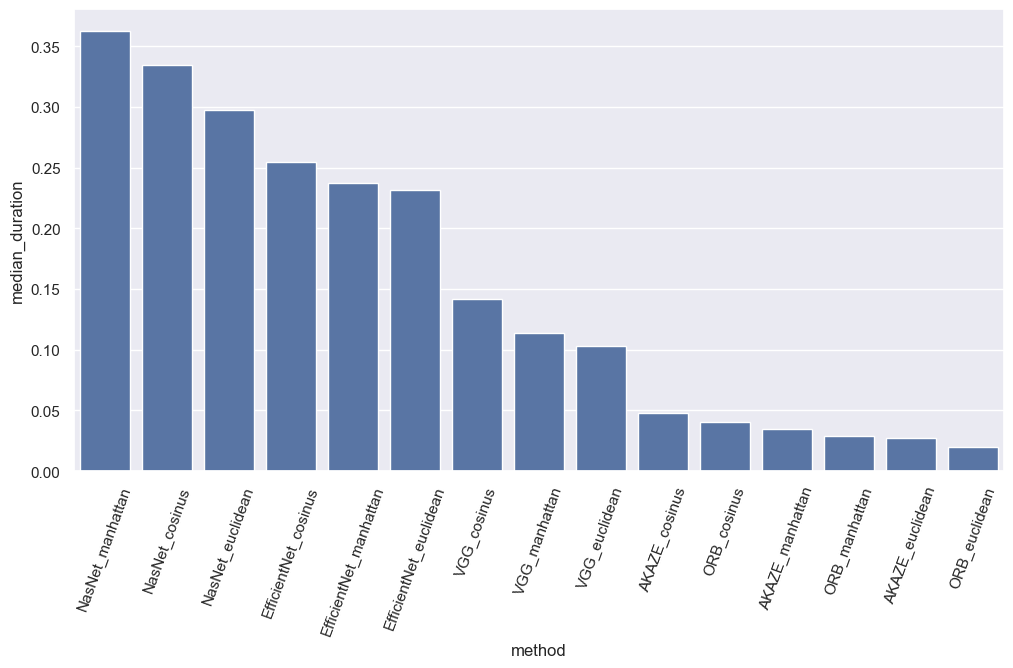

In [74]:
sns.barplot(data=evaluation_color.sort("median_duration", descending=True), x="method", y="median_duration")
plt.xticks(rotation=70)
plt.show()

### Styles

In [75]:
evaluation_style = evaluation(gt_column="gt_style", pred_column="styles")
Markdown(str(evaluation_style))

| method                 | map      | mrr      | first_rank | median_duration |
|------------------------|----------|----------|------------|-----------------|
| AKAZE_cosinus          | 0.199573 | 0.205184 | 0.118981   | 0.04769         |
| AKAZE_euclidean        | 0.409305 | 0.431047 | 0.30148    | 0.027107        |
| AKAZE_manhattan        | 0.426173 | 0.448473 | 0.320967   | 0.034335        |
| ORB_cosinus            | 0.191999 | 0.195803 | 0.108863   | 0.040173        |
| ORB_euclidean          | 0.409709 | 0.429314 | 0.297171   | 0.020106        |
| ORB_manhattan          | 0.427056 | 0.446265 | 0.317407   | 0.028702        |
| VGG_cosinus            | 0.045216 | 0.047024 | 0.037849   | 0.141562        |
| VGG_euclidean          | 0.925721 | 0.938046 | 0.909687   | 0.103439        |
| VGG_manhattan          | 0.925333 | 0.938205 | 0.909874   | 0.114153        |
| NasNet_cosinus         | 0.027876 | 0.028774 | 0.015177   | 0.334193        |
| NasNet_euclidean       | 0.951403 | 0.957279 | 0.941165   | 0.297163        |
| NasNet_manhattan       | 0.946434 | 0.952114 | 0.936294   | 0.362533        |
| EfficientNet_cosinus   | 0.054451 | 0.054397 | 0.018362   | 0.254814        |
| EfficientNet_euclidean | 0.961307 | 0.968056 | 0.955031   | 0.231353        |
| EfficientNet_manhattan | 0.961913 | 0.968765 | 0.955593   | 0.237542        |

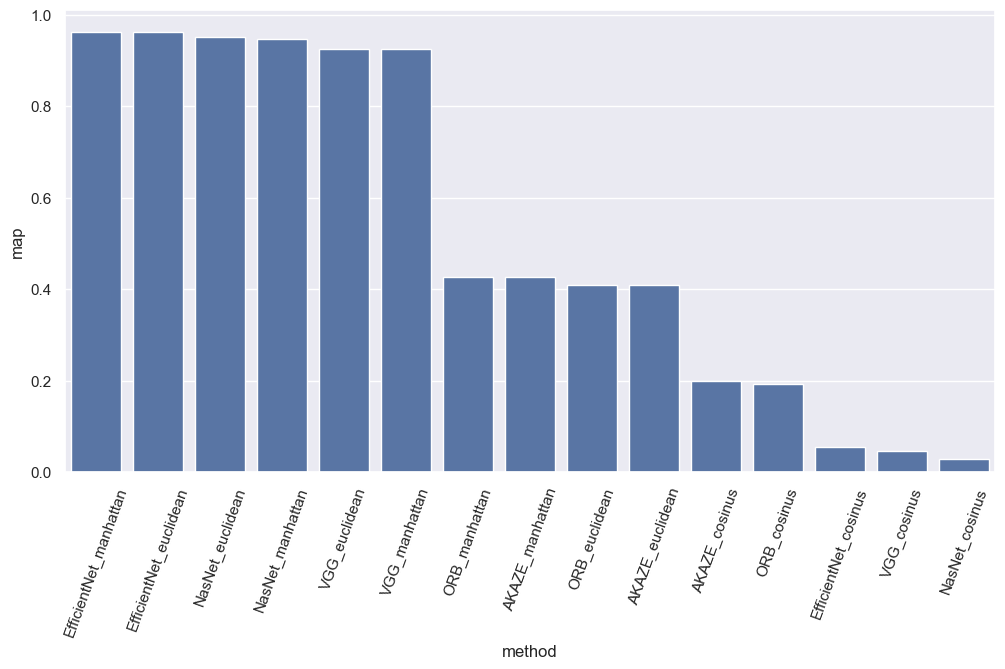

In [76]:
sns.barplot(data=evaluation_style.sort("map", descending=True), x="method", y="map")
plt.xticks(rotation=70)
plt.show()

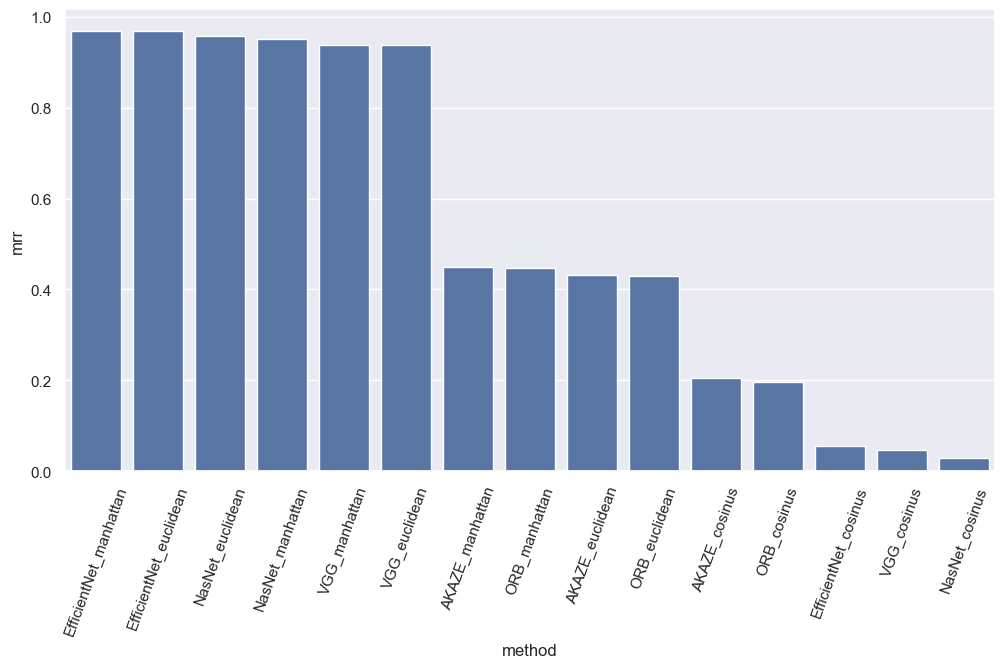

In [77]:
sns.barplot(data=evaluation_style.sort("mrr", descending=True), x="method", y="mrr")
plt.xticks(rotation=70)
plt.show()

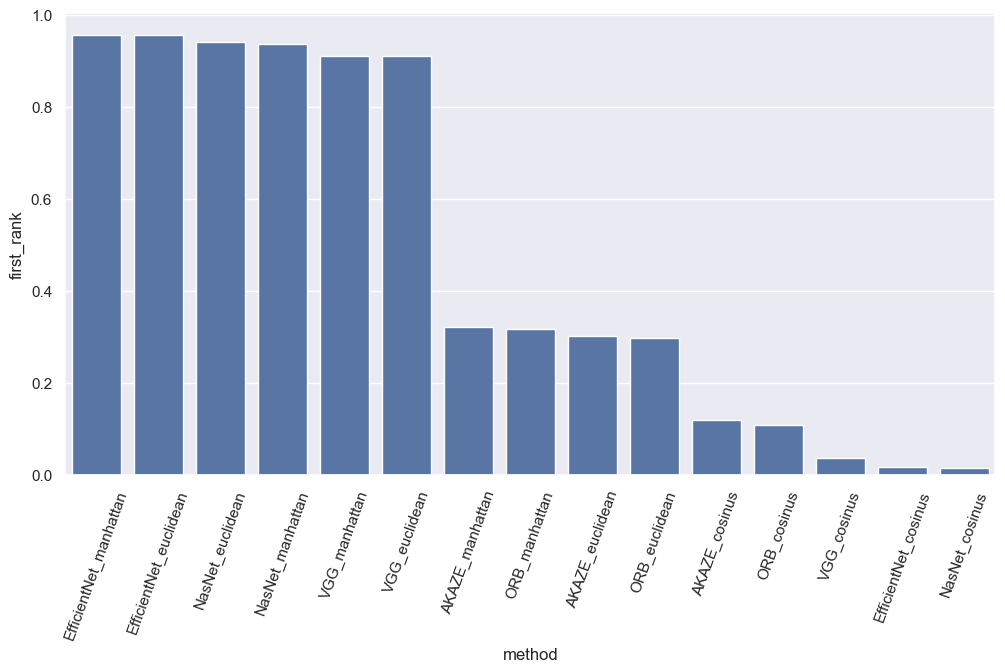

In [78]:
sns.barplot(data=evaluation_style.sort("first_rank", descending=True), x="method", y="first_rank")
plt.xticks(rotation=70)
plt.show()

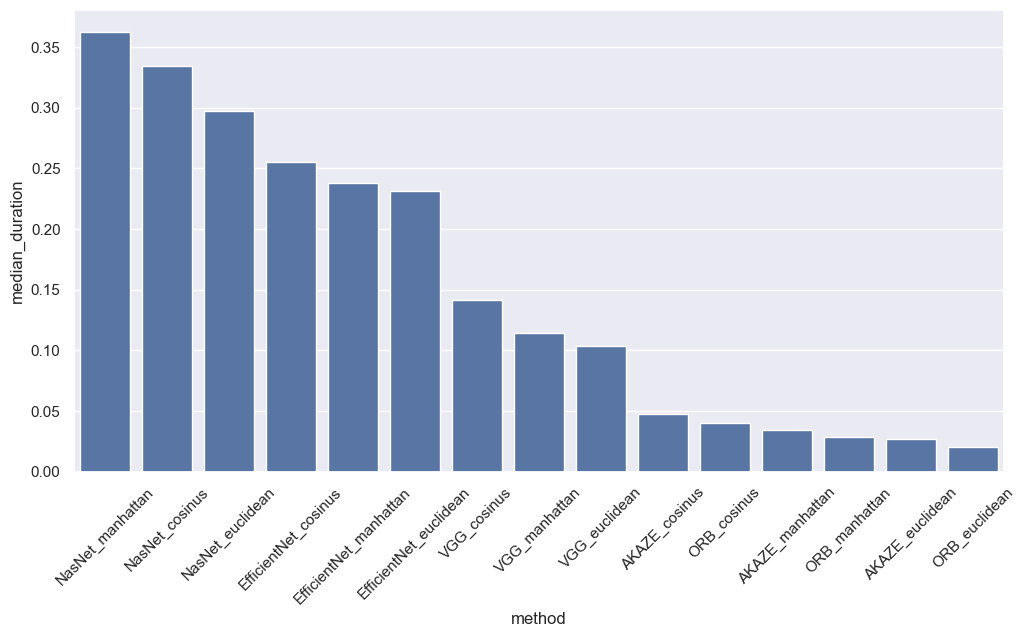

In [79]:
sns.barplot(data=evaluation_style.sort("median_duration", descending=True), x="method", y="median_duration")
plt.xticks(rotation=45)
plt.show()

### Colors & Styles

In [80]:
evaluation_color_style = evaluation(gt_column="ground_truth", pred_column="returns")
Markdown(str(evaluation_color_style))

| method                 | map      | mrr      | first_rank | median_duration |
|------------------------|----------|----------|------------|-----------------|
| AKAZE_cosinus          | 0.042395 | 0.041974 | 0.020423   | 0.04769         |
| AKAZE_euclidean        | 0.19283  | 0.198229 | 0.128349   | 0.027107        |
| AKAZE_manhattan        | 0.196957 | 0.202442 | 0.133034   | 0.034335        |
| ORB_cosinus            | 0.042541 | 0.042736 | 0.02136    | 0.040173        |
| ORB_euclidean          | 0.188706 | 0.194775 | 0.126663   | 0.020106        |
| ORB_manhattan          | 0.202788 | 0.210324 | 0.141653   | 0.028702        |
| VGG_cosinus            | 0.002997 | 0.002982 | 0.001312   | 0.141562        |
| VGG_euclidean          | 0.721211 | 0.753857 | 0.657298   | 0.103439        |
| VGG_manhattan          | 0.719884 | 0.75178  | 0.6543     | 0.114153        |
| NasNet_cosinus         | 0.003925 | 0.003925 | 0.001499   | 0.334193        |
| NasNet_euclidean       | 0.689844 | 0.720961 | 0.621698   | 0.297163        |
| NasNet_manhattan       | 0.683578 | 0.714996 | 0.619449   | 0.362533        |
| EfficientNet_cosinus   | 0.006272 | 0.006314 | 0.001874   | 0.254814        |
| EfficientNet_euclidean | 0.731495 | 0.765105 | 0.670789   | 0.231353        |
| EfficientNet_manhattan | 0.726377 | 0.758535 | 0.661046   | 0.237542        |

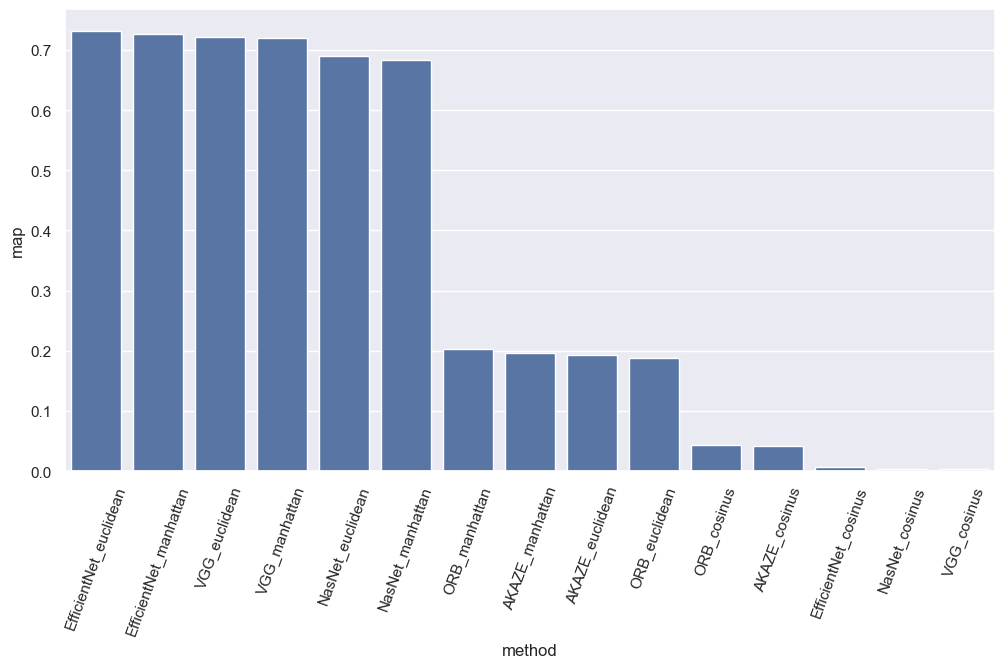

In [81]:
sns.barplot(data=evaluation_color_style.sort("map", descending=True), x="method", y="map")
plt.xticks(rotation=70)
plt.show()

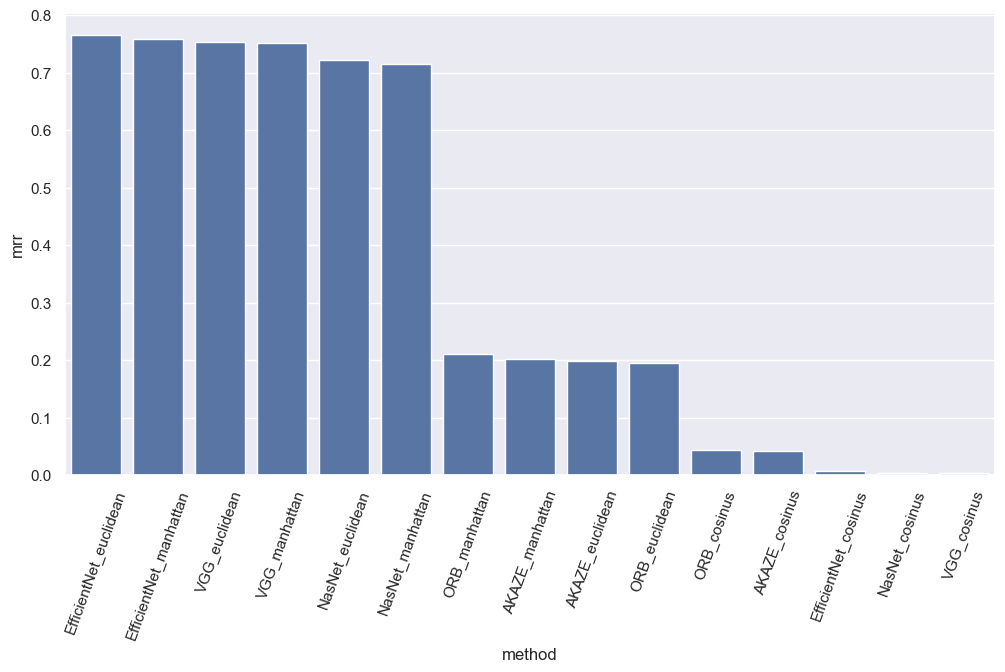

In [82]:
sns.barplot(data=evaluation_color_style.sort("mrr", descending=True), x="method", y="mrr")
plt.xticks(rotation=70)
plt.show()

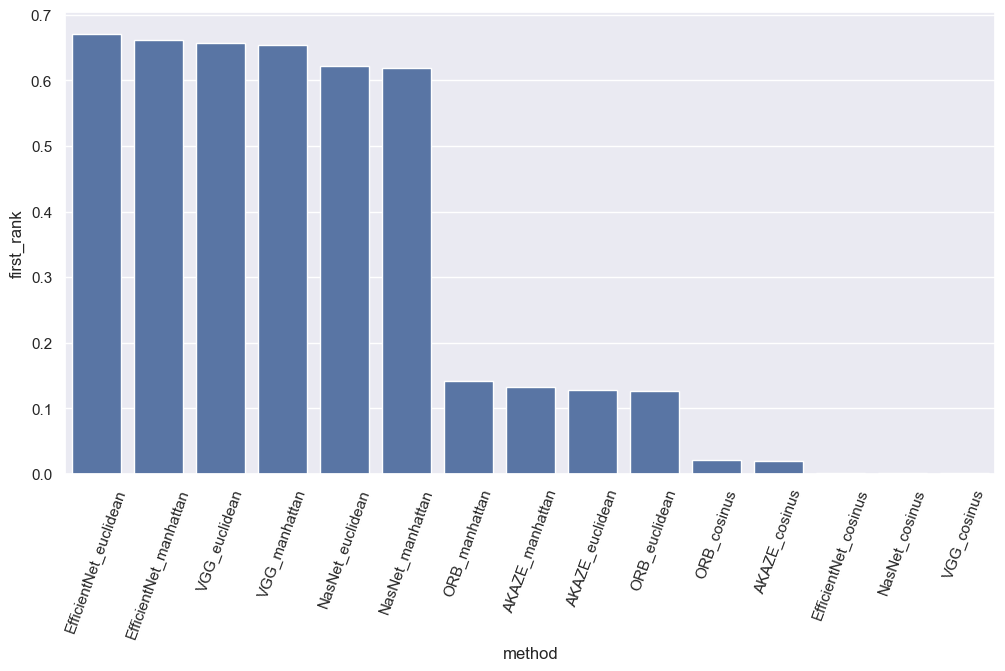

In [83]:
sns.barplot(data=evaluation_color_style.sort("first_rank", descending=True), x="method", y="first_rank")
plt.xticks(rotation=70)
plt.show()

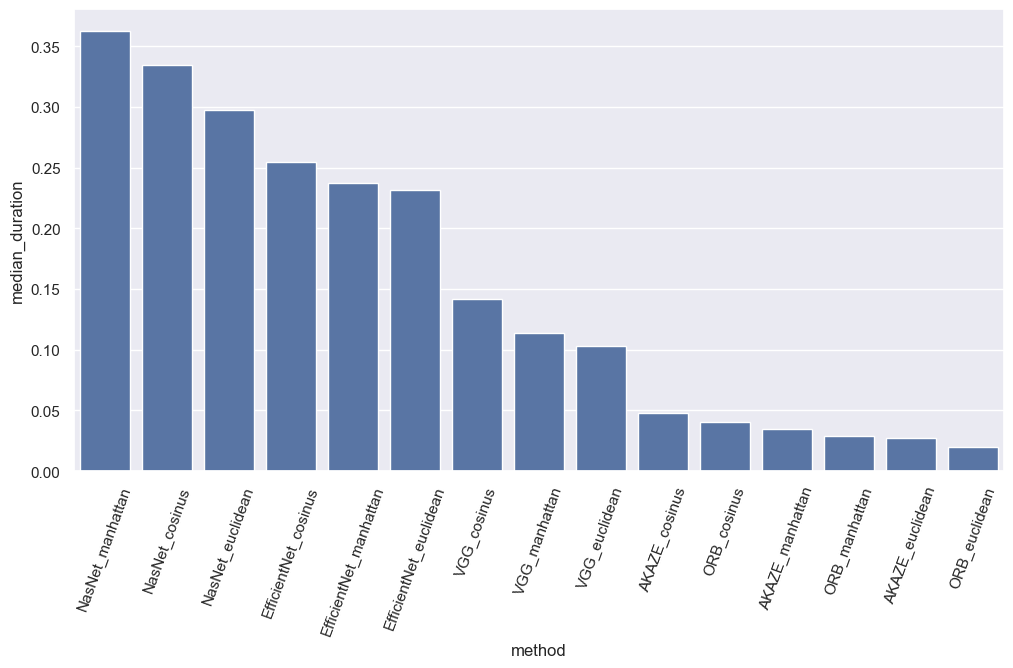

In [84]:
sns.barplot(data=evaluation_color_style.sort("median_duration", descending=True), x="method", y="median_duration")
plt.xticks(rotation=70)
plt.show()

## Conclusion

Quelle que soit la méthode utilisée, la distance de cosinus présente la performance la moins satisfaisante. En revanche, les distances de Manhattan et euclidienne affichent des résultats assez similaires.

Les réseaux de neurones surpassent les descripteurs sur tous les critères d'évaluation.